## Data Analytics final project <br>
Authors: Piotr Pawełczak, Mateusz Pilecki

## Project formulation <br>
[Pecio]
-is the problem clearly stated [1 pt] <br>
-what is the point of creating model, are potential use cases defined [1 pt] <br>

## Data import and preprocessing

Dataset comes from https://www.kaggle.com/datasets/beksultankarimov/warsaw-flat-rent-prices. <br>
In the link there is data collected by person, who lives in Warsaw and wanted to rent a flat. <br>
Source of the data is page www.otodom.pl

In [1]:
# Import libraries to handle data
import pandas as pd
import arviz as az
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
from DA_tools.DA_colors import *
from DA_tools.DA_tools import ribbon_plot

In [2]:
# Load and visualizate data
raw_data = pd.read_csv('otodom_complete.csv')
raw_data.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'offer_url',
       'offer_url-href', 'location', 'net_price', 'deposit', 'area',
       'room_num', 'build_type', 'floor', 'total_floor', 'build_mat',
       'windows', 'heating', 'year_built', 'status', 'agd', 'security',
       'add_info', 'rest_info', 'offer_ID', 'next_pagination',
       'next_pagination-href', 'add_cost', 'offer_last_update', 'second_page',
       'second_page-href', 'third_page', 'third_page-href'],
      dtype='object')

In [3]:
raw_data.head()

,web-scraper-order,web-scraper-start-url,offer_url,offer_url-href,location,net_price,deposit,area,room_num,build_type,...,rest_info,offer_ID,next_pagination,next_pagination-href,add_cost,offer_last_update,second_page,second_page-href,third_page,third_page-href
0,1612265907-2487,https://www.otodom.pl/wynajem/mieszkanie/warsz...,37 m²\n \n ...,https://www.otodom.pl/pl/oferta/wynajme-od-zar...,"Warszawa, Włochy, ul. 1 Sierpnia",2 100 zł,Kaucja:2 100 zł,Powierzchnia:37 m²,Liczba pokoi:2,NaN,...,klimatyzacja,Nr oferty w Otodom: 61451923,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,NaN,Data aktualizacji: 3 dni temu,NaN,NaN,NaN,NaN
1,1612264314-1965,https://www.otodom.pl/wynajem/mieszkanie/warsz...,38 m²\n \n ...,https://www.otodom.pl/pl/oferta/2-pokoje-tanio...,"Warszawa, Mokotów, ul. Suwak 11",1 825 zł,Kaucja:3 400 zł,Powierzchnia:38 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,...,garaż/miejsce parkingowewindapom. użytkowe,Nr oferty w Otodom: 61405987,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,Czynsz - dodatkowo:350 zł,Data aktualizacji: 2 dni temu,NaN,NaN,NaN,NaN
2,1612263242-1616,https://www.otodom.pl/wynajem/mieszkanie/warsz...,57 m²\n \n ...,https://www.otodom.pl/pl/oferta/wynajme-mieszk...,"Warszawa, Bielany, ul. Kwitnąca",3 300 zł,Kaucja:3 300 zł,Powierzchnia:57 m²,Liczba pokoi:3,Rodzaj zabudowy:blok,...,balkontylko dla niepalącychoddzielna kuchnia,Nr oferty w Otodom: 61375474,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,Czynsz - dodatkowo:1 zł,Data aktualizacji: 22 dni temu,NaN,NaN,NaN,NaN
3,1612265477-2346,https://www.otodom.pl/wynajem/mieszkanie/warsz...,63 m²\n \n ...,https://www.otodom.pl/pl/oferta/zielone-zacisz...,"Warszawa, Targówek, ul. św. Wincentego",2 200 zł,NaN,Powierzchnia:63 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,...,NaN,Nr oferty w Otodom: 61439492,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,NaN,Data aktualizacji: 5 dni temu,NaN,NaN,NaN,NaN
4,1612266187-2579,https://www.otodom.pl/wynajem/mieszkanie/warsz...,65 m²\n \n ...,https://www.otodom.pl/pl/oferta/eleganckie-mie...,"Warszawa, Ochota, Stara Ochota, ul. Juliana Ur...",3 000 zł,Kaucja:3 000 zł,Powierzchnia:65 m²,Liczba pokoi:3,Rodzaj zabudowy:kamienica,...,NaN,Nr oferty w Otodom: 61455072,NaN,NaN,NaN,Data aktualizacji: 2 dni temu,NaN,NaN,NaN,NaN


Dataset contains various parameters such as offert_url, location, price netto, deposit, area, <br>
aditional features of flat (such as air conditioning, alarm system, type of building).

#### Preprocessing

In our case we want to find relation between area of flat and price. Area can be selected from column 'offer_url'. <br>
Informations about price are located in columns 'net_price' and 'add_cost'.

In [4]:
# Selecting important columns
clipped_data = raw_data[['offer_url', 'net_price', 'add_cost']]
clipped_data.head()

,offer_url,net_price,add_cost
0,37 m²\n \n ...,2 100 zł,NaN
1,38 m²\n \n ...,1 825 zł,Czynsz - dodatkowo:350 zł
2,57 m²\n \n ...,3 300 zł,Czynsz - dodatkowo:1 zł
3,63 m²\n \n ...,2 200 zł,NaN
4,65 m²\n \n ...,3 000 zł,NaN


In [5]:
# Extract area of flat
data = pd.DataFrame()
selected_area = clipped_data['offer_url'].str.split(' m', expand=True)[0]

# Convert to numeric format 
selected_area = selected_area.str.replace(',', '.').astype(float)
data['area'] = selected_area

In [6]:
# Select net_price
net_price = clipped_data['net_price'].str[:-3] # Remove currency info (PLN)
net_price = net_price.str.replace(' ', '') # Remove white spaces
net_price = net_price.str.replace(',', '.').astype(float) # Convert to float type
data['net_price'] = net_price

# Select additional cosst
add_cost = clipped_data['add_cost'].str.split(':', expand=True)[1] # Select part with cost info
add_cost = add_cost.str[:-3] # Remove currency info (PLN)
add_cost = add_cost.str.replace(' ', '') # Remove white spaces
add_cost = add_cost.str.replace(',', '.').astype(float) # Convert to float type

data['add_cost'] = add_cost


In result we get data with following structure

In [7]:
data.head()

,area,net_price,add_cost
0,37.0,2100.0,NaN
1,38.0,1825.0,350.0
2,57.0,3300.0,1.0
3,63.0,2200.0,NaN
4,65.0,3000.0,NaN


Information about data

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3482 entries, 0 to 3481
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area       3482 non-null   float64
 1   net_price  3481 non-null   float64
 2   add_cost   1915 non-null   float64
dtypes: float64(3)
memory usage: 81.7 KB


To clean data, rows with NaN in net_price will be deleted and NaN in add_cost will be replaced with 0

In [9]:
data = data[pd.notnull(data['net_price'])]
data['add_cost'] = data['add_cost'].fillna(0)

In [10]:
# Convert data to integers
data['area'] = data['area'].astype(int)
data['net_price'] = data['net_price'].astype(int)
data['add_cost'] = data['add_cost'].astype(int)

# Calculate total price
data['total_price'] = data['net_price'] + data['add_cost']

# Save data to csv
data.to_csv('cleaned_data.csv')

In [11]:
# Filter data to reasonable values
data = data[data['area'] <= 100]
data = data[data['total_price'] <= 7500]


In [12]:
data.head()

,area,net_price,add_cost,total_price
0,37,2100,0,2100
1,38,1825,350,2175
2,57,3300,1,3301
3,63,2200,0,2200
4,65,3000,0,3000


# Priors

Priors [0-4 pts]<br>
-Is it explained why particular priors for parameters were selected [1 pt]<br>
-How prior parameters were selected [1 pt]<br>
[Szpila]

https://www.otodom.pl/pl/oferty/wynajem/mieszkanie/warszawa?by=PRICE&direction=ASC&page=1

TODO: Describe ceneteing, predictor itd. [Pecio]

In [13]:
data['c_area'] = data.area - data.area.mean()

In [14]:
data.head()

,area,net_price,add_cost,total_price,c_area
0,37,2100,0,2100,-7.3566
1,38,1825,350,2175,-6.3566
2,57,3300,1,3301,12.6434
3,63,2200,0,2200,18.6434
4,65,3000,0,3000,20.6434


TODO: Data for simulation describe [Pecio]

In [15]:
N = 50
area = np.linspace(data.c_area.min(), data.c_area.max(), N)
data_sim = {'N': N, 'area': area}

### Prior predictive check

In [16]:
normal_model_ppc = CmdStanModel(stan_file='linear_regression_ppc.stan')

R = 1000
sim_normal = normal_model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=1)

alpha_sim_normal = sim_normal.stan_variable('alpha')
beta_sim_normal = sim_normal.stan_variable('beta')
price_sim_normal = sim_normal.stan_variable('price')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


-Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]<br> [Pecio]

In [17]:
# TODO: Histogram mu sigma [Pecio]

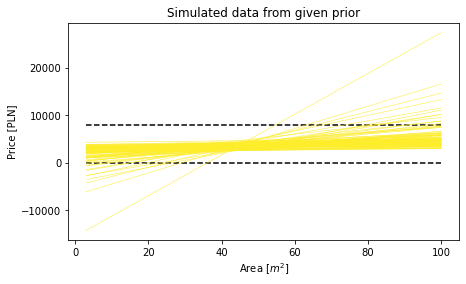

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,8000],xmin=data.area.min(),xmax=data.area.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(data.area,alpha_sim_normal[i] + beta_sim_normal[i] * data.c_area, color=MID, alpha=0.5, linewidth=0.5)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title(r'Simulated data from given prior')
plt.show()

TODO: Conclusions [Pecio]

-Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]<br> [Pecio]


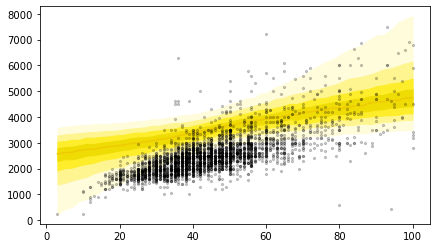

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(data_sim['area'] + data.area.mean(), price_sim_normal, axes)
axes.scatter(data.area, data.total_price, color='black', alpha=0.2,s=5)
plt.show()


In [20]:
# TODO: hist: sim_price [Pecio]

## Model [0-4 pts] [Pecio, Szpila]
-are two different models specified [1 pt] - opisać że mamy 2 różne modele <br>
-are difference between two models explained [1 pt] - różnice pomiędzy modelami <br>
-is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt] - czy jest sens mieć ten drugi model? <br>
<br>

# Model 1: Normal Distribution [Pecio]

-are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]<br>


## Posterior

In [21]:
DATA_SIZE = 300

In [22]:
model_fit_normal = CmdStanModel(stan_file="linear_regression_fit.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [23]:
d_short=data.head(DATA_SIZE)

data_fit = {
    "N": len(d_short),
    "area": d_short.c_area.values,
    "price": d_short.total_price.values
}

fit_normal = model_fit_normal.sample(data=data_fit, seed=1, chains=1)
alpha_fit_normal = fit_normal.stan_variable('alpha')
beta_fit_normal = fit_normal.stan_variable('beta')
mu_fit_normal = fit_normal.stan_variable('mu')
price_pred_normal = fit_normal.stan_variable('price_pred')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [24]:
# Diagnose fit
fit_normal.diagnose()

'Processing csv files: C:\\Users\\piotr\\AppData\\Local\\Temp\\tmp4w72w8ko\\linear_regression_fit-20220613152640.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

According to diagnose result, there were no problems with sampling. Model is well defined.

In [25]:
az.summary(fit_normal, var_names=['alpha', 'beta', 'sigma'], kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,2523.73,29.83,2466.62,2576.11
beta,38.37,1.99,34.55,42.03
sigma,535.27,21.72,492.88,573.54


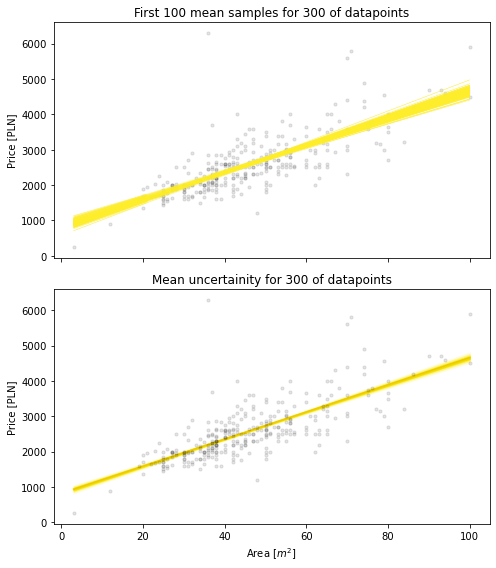

In [26]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes[0]

NUM_OF_SAMPLES = 100
for i in range(NUM_OF_SAMPLES):
    ax0.plot(d_short.area,
              alpha_fit_normal[i] + beta_fit_normal[i] * d_short.c_area,
              color=MID,
              alpha=0.5,linewidth=0.5)

ax0.scatter(d_short.area,d_short.total_price,color='black',alpha=0.1,s=10)
ax0.set_ylabel('Price [PLN]')
ax0.set_title('First {} mean samples for {} of datapoints'.format(NUM_OF_SAMPLES, len(d_short)))

ax1=axes[1]
ax1=ribbon_plot(d_short.area.values, mu_fit_normal, ax1, supress_warning=True)
ax1.scatter(d_short.area, d_short.total_price, color='black', alpha=0.1, s=10)
ax1.set_xlabel('Area [$m^2$]')
ax1.set_ylabel('Price [PLN]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short)))
fig.tight_layout()
plt.show()

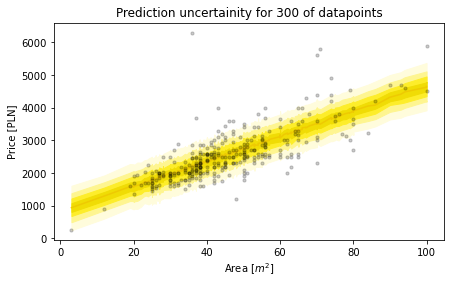

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))

axes = ribbon_plot(d_short.area.values, price_pred_normal, axes,supress_warning=True)
axes.scatter(d_short.area, d_short.total_price,color='black',alpha=0.2,s=10)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.show()

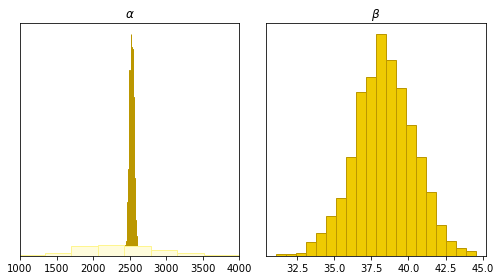

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax = axes[0]
ax.hist(alpha_fit_normal, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
ax.hist(data.total_price, bins=20,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax.set_xlim(1000, 4000)

ax2 = axes[1]
ax2.hist(beta_fit_normal, bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

## Marginal for selected area

In [29]:
def plot_marginal(area: int, type="normal"):

    if type == "normal":
        marginal_mu = alpha_fit_normal + beta_fit_normal * (area - data.area.mean())
    elif type == "student":
        marginal_mu = alpha_fit_student + beta_fit_student * (area - data.area.mean())

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.hist(marginal_mu, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
    ax.set_title(f'Mean for area {area}$m^2$')
    ax.set_yticks(())
    ax.set_xlabel(f'mu|area={area} $m^2$')
    plt.show()

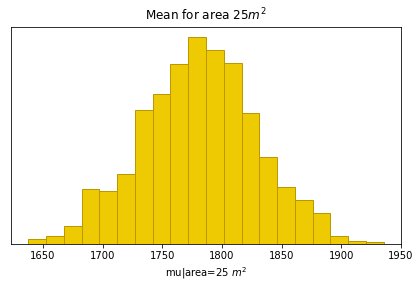

In [30]:
plot_marginal(25)


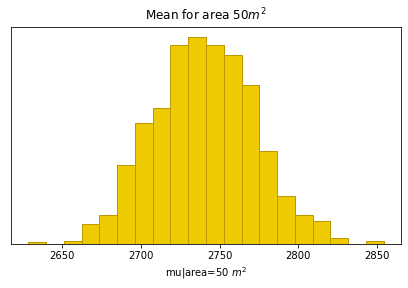

In [31]:
plot_marginal(50)


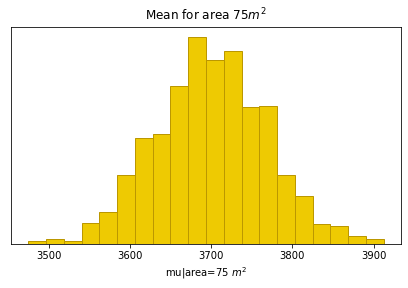

In [32]:
plot_marginal(75)


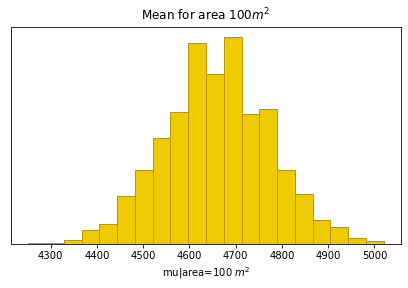

In [33]:
plot_marginal(100)


TODO: Conclusions

# Model 2: Student T Distribution [Szpila]

-are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]<br>


## Posterior

In [35]:
model_fit_student = CmdStanModel(stan_file="student_fit.stan")

INFO:cmdstanpy:compiling stan file C:\Users\piotr\Desktop\ISZ\Semestr 1\data_analytics_2022\Project\student_fit.stan to exe file C:\Users\piotr\Desktop\ISZ\Semestr 1\data_analytics_2022\Project\student_fit.exe
INFO:cmdstanpy:compiled model executable: C:\Users\piotr\Desktop\ISZ\Semestr 1\data_analytics_2022\Project\student_fit.exe


In [36]:
d_short=data.head(DATA_SIZE)

data_fit = {
    "N": len(d_short),
    "area": d_short.c_area.values,
    "price": d_short.total_price.values
}

fit_student = model_fit_student.sample(data=data_fit,seed=1, chains=1)
alpha_fit_student = fit_student.stan_variable('alpha')
beta_fit_student = fit_student.stan_variable('beta')
mu_fit_student = fit_student.stan_variable('mu')
price_pred_student = fit_student.stan_variable('price_pred')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [37]:
# Fit diagnose
fit_student.diagnose()

'Processing csv files: C:\\Users\\piotr\\AppData\\Local\\Temp\\tmp4w72w8ko\\student_fit-20220613152813.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

According to diagnose result, there were no problems with sampling. Model is well defined.

In [38]:
az.summary(fit_student, var_names=['alpha', 'beta', 'sigma'], kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,2471.22,23.74,2424.07,2511.23
beta,37.26,1.71,34.01,40.38
sigma,348.38,26.34,294.05,392.36


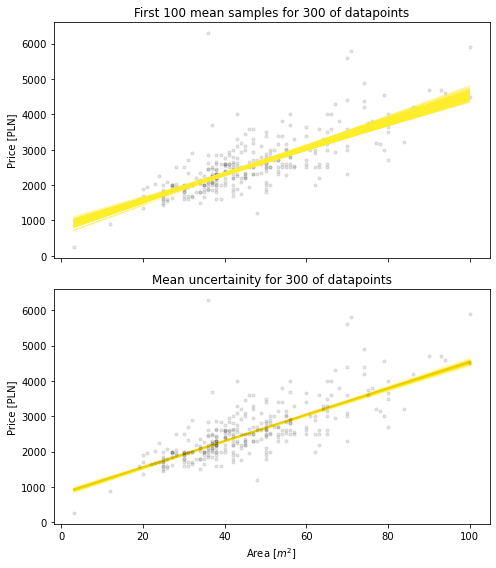

In [39]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes[0]

for i in range(NUM_OF_SAMPLES):
    ax0.plot(d_short.area,
              alpha_fit_student[i] + beta_fit_student[i] * d_short.c_area,
              color=MID,
              alpha=0.5,linewidth=0.5)

ax0.scatter(d_short.area, d_short.total_price, color='black', alpha=0.1, s=10)
ax0.set_ylabel('Price [PLN]')
ax0.set_title('First {} mean samples for {} of datapoints'.format(NUM_OF_SAMPLES, len(d_short)))

ax1=axes[1]
ax1=ribbon_plot(d_short.area.values, mu_fit_student, ax1, supress_warning=True)
ax1.scatter(d_short.area, d_short.total_price, color='black', alpha=0.1, s=10)
ax1.set_xlabel('Area [$m^2$]')
ax1.set_ylabel('Price [PLN]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short)))
fig.tight_layout()
plt.show()

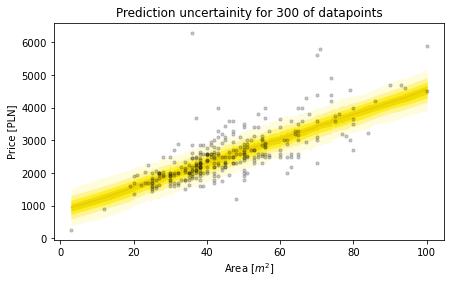

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.area.values, price_pred_student, axes, supress_warning=True)
axes.scatter(d_short.area, d_short.total_price,color='black',alpha=0.2,s=10)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.show()

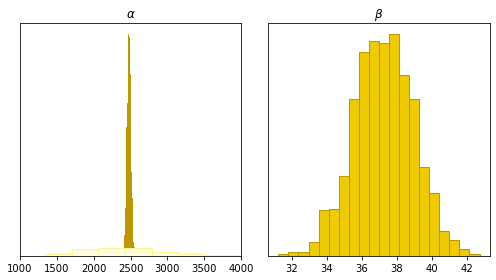

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax = axes[0]
ax.hist(alpha_fit_student, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
ax.hist(data.total_price, bins=20, color=LIGHT, edgecolor=LIGHT_HIGHLIGHT,density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax.set_xlim(1000, 4000)

ax2 = axes[1]
ax2.hist(beta_fit_student, bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

## Marginal for selected area

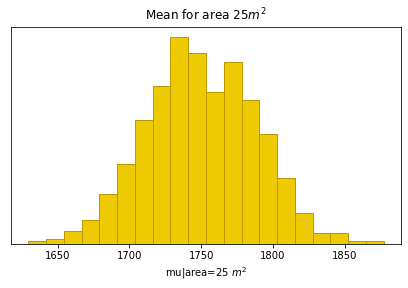

In [42]:
plot_marginal(25, type="student")

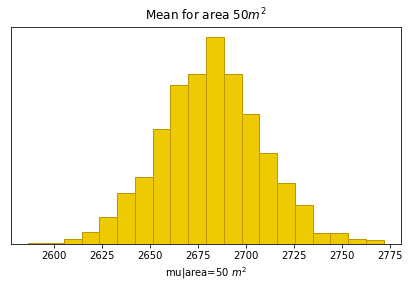

In [43]:
plot_marginal(50, type="student")

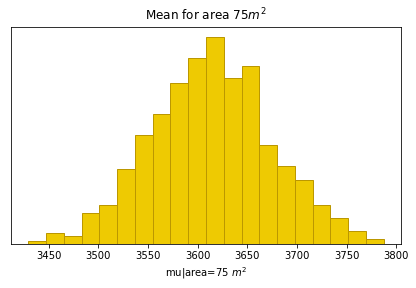

In [44]:
plot_marginal(75, type="student")

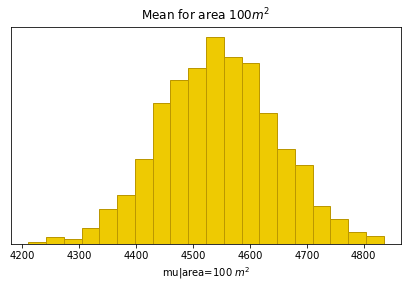

In [45]:
plot_marginal(100, type="student")

# Model comparision

<br>
Model comaprison [0-4 pts]<br>
-Have models been compared using information criteria [1 pt]<br>
-Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]<br>
-Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]<br>
-Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]<br>

[Szpila] Opis wykresów byle jaki

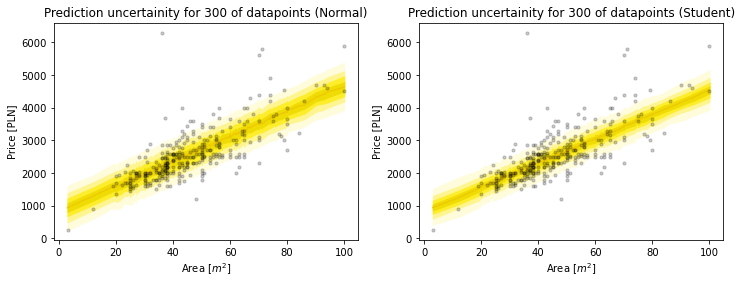

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax = ribbon_plot(d_short.area.values, price_pred_normal, ax,supress_warning=True)
ax.scatter(d_short.area, d_short.total_price, color='black', alpha=0.2, s=10)
ax.set_xlabel('Area [$m^2$]')
ax.set_ylabel('Price [PLN]')
ax.set_title('Prediction uncertainity for {} of datapoints (Normal)'.format(len(d_short)))

ax1 = axes[1]
ax1 = ribbon_plot(d_short.area.values, price_pred_student, ax1, supress_warning=True)
ax1.scatter(d_short.area, d_short.total_price, color='black', alpha=0.2, s=10)
ax1.set_xlabel('Area [$m^2$]')
ax1.set_ylabel('Price [PLN]')
ax1.set_title('Prediction uncertainity for {} of datapoints (Student)'.format(len(d_short)))

plt.show()

In [47]:
az.summary(fit_normal, var_names=['alpha','beta','sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,2523.73,29.83,2466.62,2576.11
beta,38.37,1.99,34.55,42.03
sigma,535.27,21.72,492.88,573.54


In [48]:
az.summary(fit_student, var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,2471.22,23.74,2424.07,2511.23
beta,37.26,1.71,34.01,40.38
sigma,348.38,26.34,294.05,392.36


LOO - leave-one-out

In [49]:
arviz_result_normal = az.from_cmdstanpy(posterior=fit_normal)
arviz_result_student = az.from_cmdstanpy(posterior=fit_student)

In [55]:
model_compare_loo = az.compare(dataset_dict ={
    'Normal model':arviz_result_normal, 
    'Student-t model':arviz_result_student
    })

e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([

In [56]:
model_compare_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Student-t model,0,-2274.223242,4.907528,0.000000,0.920275,18.600772,0.000000,False,log
Normal model,1,-2317.005887,10.073639,42.782645,0.079725,36.244361,25.320937,True,log


Parameters: <br>
rank - indicates which model is better (rank 0 is the best model) - Student-t model performes better than normal model <br>
loo - Information Criterion, higher loo indicates higher out-of-sample predictive fit ("better model") - Studen-t performes better <br>
p_loo - Estimated effective number of parameters <br>
d_loo - Relative difference between each loo <br>
weight - Relative weight for each model (probability of each model given data) <br>
se - Standard error of the IC estimate <br>
dse - Standard error of the difference in IC between each model and the top-ranked model. <br>

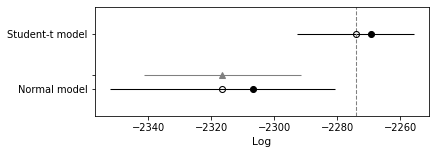

In [62]:
az.plot_compare(model_compare_loo)
plt.show()

Open black dot - value of LOO <br>
Filled black dot - LOO + p_loo <br>
Line size - 2 * SE (Standard Error) <br>
Distance between filled black dots - d_loo <br>
Line with traingle - error of the best model showed for better comparision visualization

Conclusions - clearlu winner jest [Szpila]

WAIC - widely applicable information criterion

In [58]:
model_compare_waic = az.compare(dataset_dict ={
    'Normal model':arviz_result_normal, 
    'Student-t model':arviz_result_student
    }, ic="waic")

e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The

In [59]:
model_compare_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Student-t model,0,-2274.176214,4.860499,0.000000,0.920266,18.580418,0.000000,True,log
Normal model,1,-2316.498830,9.566582,42.322616,0.079734,35.795364,24.885564,True,log


Parameters: <br>
rank - indicates which model is better (rank 0 is the best model) - Student-t model performes better than normal model <br>
waic - Information Criterion, higher waic indicates higher out-of-sample predictive fit ("better model") - Studen-t performes better <br>
p_waic - Estimated effective number of parameters <br>
d_waic - Relative difference between each waic <br>
weight - Relative weight for each model (probability of each model given data) <br>
se - Standard error of the IC estimate <br>
dse - Standard error of the difference in IC between each model and the top-ranked model. <br>

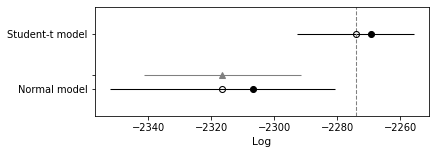

In [60]:
az.plot_compare(model_compare_waic)
plt.show()

Open black dot - value of waic <br>
Filled black dot - waic + p_waic <br>
Line size - 2 * SE (Standard Error) <br>
Distance between filled black dots - d_waic <br>
Line with traingle - error of the best model showed for better comparision visualization

[Szpila] Conculsions like in loo

## General conclusion [Szpila, Pecio]